In [36]:
import pandas as pd
import torch
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
import torch
import numpy as np

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

---

**data cleansing** 

In [9]:
def remove_numeric(text):
    return re.sub(r'\d+', '', text)


# define the regular expression pattern to match the label and text
pattern = r"^(\d)\t(.+)$"

# create an empty list to store the data
data = []

# open the text file and iterate through each line
with open("VideoCommentsThreatCorpus.txt", "r") as file:
    for line in file:
        # remove any leading/trailing white spaces
        line = line.strip()
        # check if the line matches the pattern
        match = re.match(pattern, line)
        if match:
            # extract the label and text from the matched line
            label = int(match.group(1))
            text = match.group(2)
            # append the label and text to the data list
            data.append([text, label])

# create a Pandas dataframe from the data list

df = pd.DataFrame(data, columns=["text", "label"])

df["text"] = df["text"].apply(lambda x: remove_numeric(x))

In [10]:
df = df.drop_duplicates()

def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

df['text'] = df['text'].apply(remove_special_characters)

df['text'] = df['text'].apply(lambda x: x.lower())

**determine max_sequence_length of your data**

<Axes: >

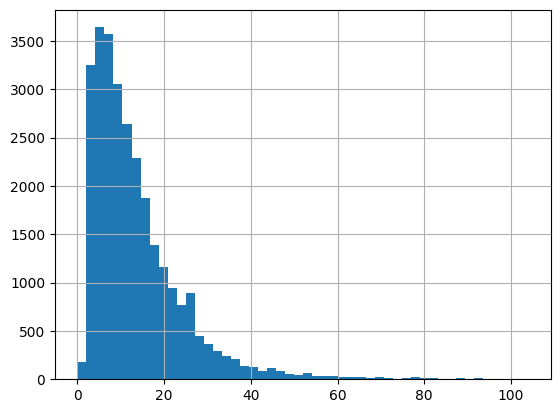

In [11]:
seq_len = [len(row.split()) for row in df["text"]]
pd.Series(seq_len).hist(bins=50)

In [12]:
max_length = 40

indexes = []

for i, row in df.iterrows():

    if len(row["text"].split()) > max_length:

        indexes.append(i)

df.drop(indexes, inplace=True)

stemming and lemmatization

In [13]:
nltk.download("punkt")
nltk.download("wordnet")

# Instantiate the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function to apply stemming and lemmatization to a sentence
def stem_and_lemmatize(sentence):
    # Tokenize the sentence into words
    words = nltk.word_tokenize(sentence.lower())
    # Apply stemming to each word
    stemmed_words = [stemmer.stem(word) for word in words]
    # Apply lemmatization to each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    # Join the lemmatized words back into a sentence
    lemmatized_sentence = " ".join(lemmatized_words)
    return lemmatized_sentence


# Apply the stem_and_lemmatize function to your text data
df["text"] = df["text"].apply(stem_and_lemmatize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


---

**statisticall information of dataset**

In [14]:
threaten_comment    = df[df["label"] == 1]
un_threaten_comment = df[df["label"] == 0]

In [15]:
print(f"size of the dataset : {df.shape[0]} ")
print(f"size of threaten comments : {threaten_comment.shape[0] } ")
print(f"size of un_threaten comments : {un_threaten_comment.shape[0] } ")

size of the dataset : 27425 
size of threaten comments : 1302 
size of un_threaten comments : 26123 


In [16]:
print("threaten comments")
threaten_comment.head()

threaten comments


,text,label
2,but it okbecaus europ will soon rebel against ...,1
13,all it mean is there will be more of you to kill,1
35,i just hope when multicultur prove to be a rea...,1
70,death to islam,1
75,the quran can go burn itself in hell,1


In [17]:
print("un-threaten comments")
un_threaten_comment.head()

un-threaten comments


,text,label
0,it becaus european do not want to chang their ...,0
1,the muslim there do not want to assimil proper...,0
3,i forse a big civil war in europ in the futur ...,0
4,islam a simpl humanitarian and attract religion,0
5,welcom to islam,0


---

**sampling methods**

Stratified Sampling

In [18]:
from sklearn.model_selection import train_test_split
# Stratified sampling
X = df["text"]
y = df["label"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y)

In [19]:
train_y.value_counts()[0] , train_y.value_counts()[1]

(20898, 1042)

In [20]:
test_y.value_counts()[0] , test_y.value_counts()[1]

(5225, 260)

balanced sampling : Sample as much minority data as majority data

In [21]:
balanced_unthreaten = un_threaten_comment.sample(n = threaten_comment.shape[0] , random_state=42)

In [22]:
balanced_unthreaten

,text,label
1603,your fuck countri becaus you want to see the e...,0
12947,imagin yourself be born in an european countri...,0
11977,hahah you guysi wouldnt be surpris if there wa...,0
17109,vitray of evameyrovitch research and director ...,0
17231,so devil can be kill just by ray of sun,0
...,...,...
16556,second of all the arab did creat algebra look ...,0
16752,im not pull for thi man at all im not readi to...,0
3380,i find youll think it doe,0
3356,but the law is not on your side mate,0


**we will use the balanced sampling method**

---

train test split

In [23]:
dataset = pd.concat([balanced_unthreaten, threaten_comment])
dataset

,text,label
1603,your fuck countri becaus you want to see the e...,0
12947,imagin yourself be born in an european countri...,0
11977,hahah you guysi wouldnt be surpris if there wa...,0
17109,vitray of evameyrovitch research and director ...,0
17231,so devil can be kill just by ray of sun,0
...,...,...
28602,if that look like happen all your devil shrine...,1
28609,we must creat a new hitler that will destroy e...,1
28616,kill them all,1
28617,in poland and ukrain they kill muslim,1


In [24]:
X = dataset["text"]
y = dataset["label"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y)

In [25]:
print(f"value count of train_y \n{train_y.value_counts()} ")
print(f"value count of test_y \n{test_y.value_counts()} ")

value count of train_y 
0    1042
1    1041
Name: label, dtype: int64 
value count of test_y 
1    261
0    260
Name: label, dtype: int64 


---

In [26]:
train_df = pd.concat([train_X, train_y], axis=1)
test_df  = pd.concat([test_X, test_y], axis=1)

In [27]:
print(f"train_data.shape  : {train_df.shape}")

train_df.head()

train_data.shape  : (2083, 2)


,text,label
13464,muslim should be deport from all western land,1
2538,go ahead if you ever onc think about carri out...,1
27042,kill them all,1
2114,now what ha thi to do with the muslim of today,0
5704,wrotegood for you read more of the holi quran,0


In [28]:
print(f"test_data.shape  : {test_df.shape}")

test_df.head()

test_data.shape  : (521, 2)


,text,label
15368,i pray for your gener to die out,1
26273,hehe polskojzyczni jaki,0
17620,plea ani one want to pick up the debat il crus...,1
21721,like a snake,0
11880,tun tun lmao special fuck you to all american too,0


---

get the tf-idf matrix of dataset

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    ngram_range=(1, 2),
    min_df=0.001,
    max_df=0.8)

X_train_tf = vectorizer.fit_transform(train_df["text"])
X_test_tf = vectorizer.transform(test_df["text"])

X_train_tf

<2083x2205 sparse matrix of type '<class 'numpy.float64'>'
	with 27868 stored elements in Compressed Sparse Row format>

**dimension reduction using svd on tf_idf matrix**

In [54]:
from sklearn.decomposition import TruncatedSVD

In [57]:
truncated_svd = TruncatedSVD(n_components=200, random_state=0)
X_train_reduced = truncated_svd.fit_transform(X_train)
X_test_reduced = truncated_svd.transform(X_test)
X_train_reduced.shape, X_test_reduced.shape

((2083, 200), (521, 200))

In [56]:
truncated_svd.explained_variance_ratio_.sum()

0.49293074027072803

In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report



In [68]:
clf = MultinomialNB()
clf.fit(X_train, train_y)

# y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(classification_report(test_y, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       260
           1       0.88      0.90      0.89       261

    accuracy                           0.88       521
   macro avg       0.89      0.88      0.88       521
weighted avg       0.89      0.88      0.88       521



---

**get the word representations using pretrained bert model**

In [ ]:
! pip install transformers

In [45]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Define a function to get the CLS representation of a text using BERT
def get_cls_representation(text):

    tokens = tokenizer.batch_encode_plus(
        text,
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=max_length + 2,
        return_tensors="pt",
        return_attention_mask=True,
    )

    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    outputs = model(input_ids, attention_mask=attention_mask)
    cls_representation = outputs[0][:, 0, :]

    return cls_representation.detach().numpy()


train_text_representations = [
    get_cls_representation(train_df["text"][i : i + 64].tolist())
    for i in range(0, train_df.shape[0], 64)
]

test_text_representations = [
    get_cls_representation(test_df["text"][i : i + 64].tolist())
    for i in range(0, test_df.shape[0], 64)
]

train_rep = np.concatenate(train_text_representations).reshape((train_df.shape[0], 768))
test_rep = np.concatenate(test_text_representations).reshape((test_df.shape[0], 768))

train_df["text_represantion"] = train_rep.tolist()

test_df["text_represantion"] = test_rep.tolist()

In [47]:
train_df.head()

,text,label,text_represantion
13464,muslim should be deport from all western land,1,"[-0.5980727672576904, 0.4174318015575409, -0.4..."
2538,go ahead if you ever onc think about carri out...,1,"[0.06734813749790192, 0.14853157103061676, -0...."
27042,kill them all,1,"[0.07035636156797409, 0.5827975273132324, -0.3..."
2114,now what ha thi to do with the muslim of today,0,"[-0.03710252419114113, 0.1834038496017456, -0...."
5704,wrotegood for you read more of the holi quran,0,"[-0.15349437296390533, 0.1581261307001114, 0.0..."


In [48]:
test_df.head()

,text,label,text_represantion
15368,i pray for your gener to die out,1,"[0.14766113460063934, 0.236196368932724, 0.045..."
26273,hehe polskojzyczni jaki,0,"[-0.4059525430202484, 0.21916669607162476, -0...."
17620,plea ani one want to pick up the debat il crus...,1,"[-0.4428701102733612, 0.08135899901390076, 0.0..."
21721,like a snake,0,"[-0.2700501084327698, 0.1964525580406189, -0.1..."
11880,tun tun lmao special fuck you to all american too,0,"[-0.15307843685150146, 0.14068268239498138, 0...."
